# Download data requied for identification of spatial signatures

Morphological layer of spatial signatures requires barriers (street networks, railways, water bodies) and building footprints. Barriers are retrieved from OpenStreetMap, since their overall quality and consistency is relatively stable and coverage is nearing 100%. Building footprints will be retrived independently for each case study as OSM is good enouhg only in some cases.

**Case studies:**

- Houston
- Barcelona
- Quito
- Hong Kong
- Dar es Salaam

Area of interest for each follows boundaries of GHSL Functional Urban Areas.

## FUA

https://ghsl.jrc.ec.europa.eu/data.php

In [2]:
from download import download

In [2]:
download("https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip",
        "../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015", kind="zip")

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


'../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015'

In [3]:
download("https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/copyright.txt",
        "../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/copyright.txt",
        )

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


'../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/copyright.txt'

## OSM street networks

Fetch street network from OSM via `OSMnx` based on FUA polygon. The network should contain geometry representing morphology of space, which is in most cases reflected in a drivable network. However, there are cases where certain parts of city (i.e. historical core) are closed for traffic. Therefore, we specify our own combination of OSM tags to get as close as possible to represenation of street morphology.

In [4]:
import geopandas as gpd
import osmnx as ox

In [5]:
import warnings

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [6]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")

In [7]:
fua.head(3)

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry
0,1.0,1.0,5959,Herat,1.0,AFG,Afghanistan,139.0,60.0,888811.175807,844574.564331,44236.611476,"MULTIPOLYGON (((5529000.000 4155000.000, 55310..."
1,192.0,1.0,5964,Guzarah,1.0,AFG,Afghanistan,32.0,16.0,169489.573231,160204.260864,9285.312366,"MULTIPOLYGON (((5541000.000 4139000.000, 55420..."
2,354.0,1.0,5968,Shindand,0.0,AFG,Afghanistan,12.0,12.0,147553.403870,147553.403870,0.000000,"MULTIPOLYGON (((5573000.000 4030000.000, 55740..."


In [7]:
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology

In [12]:
cases = ['Hong Kong', 'Barcelona', 'Quito', 'Houston', 'Dar es Salaam']
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

for case in cases:
    polygon = fua_4326[fua_4326.eFUA_name == case].geometry.iloc[0]
    streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
    streets_graph = ox.projection.project_graph(streets_graph)
    gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
    gdf.highway = gdf.highway.astype(str)
    path = f'../../urbangrammar_samba/sp_sig_concept/geometry/{case}_roads_osm.pq'
    gdf[['highway', 'geometry']].to_parquet(path)
    print(f"{case} network saved to {path}")

Hong Kong network saved to ../../urbangrammar_samba/sp_sig_concept/geometry/Hong Kong_roads_osm.pq
Barcelona network saved to ../../urbangrammar_samba/sp_sig_concept/geometry/Barcelona_roads_osm.pq
Quito network saved to ../../urbangrammar_samba/sp_sig_concept/geometry/Quito_roads_osm.pq
Houston network saved to ../../urbangrammar_samba/sp_sig_concept/geometry/Houston_roads_osm.pq
Dar es Salaam network saved to ../../urbangrammar_samba/sp_sig_concept/geometry/Dar es Salaam_roads_osm.pq


## OSM building footprints

Dar es Salaam building footprints are thoroughly mapped thanks to XXX project (find that or as Monika) therefore can be used in the cluster analysis. Building footprints of Hong Kong are of a high quality and coverage and are used as well.

Hong Kong is relatively compact and can be downloaded via `OSMnx`. Dar es Salaam is a large case study so we will download it using `pyrosm`.

### Hong Kong

In [ ]:
case = 'Hong Kong'
polygon = fua_4326[fua_4326.eFUA_name == case].geometry.iloc[0]
footprints = ox.footprints.footprints_from_polygon(polygon)
footprints_proj = ox.projection.project_gdf(footprints)
path = f'../../urbangrammar_samba/sp_sig_concept/geometry/{case}_footprints_osm.pq'
footprints_proj[['building', 'building:levels', 'geometry']].to_parquet(path)
print(f"{case} network saved to {path}")

### Dar es Salaam

In [2]:
import pyrosm
from pyrosm.data import sources

In [6]:
fp = pyrosm.get_data("tanzania")
print(fp)

Downloaded Protobuf data 'tanzania-latest.osm.pbf' (461.63 MB) to:
'/tmp/pyrosm/tanzania-latest.osm.pbf'
/tmp/pyrosm/tanzania-latest.osm.pbf


In [7]:
osm = pyrosm.OSM(fp)

In [8]:
%time buildings = osm.get_buildings()

/opt/conda/lib/python3.7/site-packages/pyrosm/buildings.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None


CPU times: user 9min 13s, sys: 26.2 s, total: 9min 39s
Wall time: 9min 38s


In [15]:
polygon = fua_4326[fua_4326.eFUA_name == "Dar es Salaam"].geometry.iloc[0]

In [16]:
%time dar = buildings.iloc[buildings.sindex.query(polygon, predicate='intersects')]

CPU times: user 13.4 s, sys: 27.5 ms, total: 13.4 s
Wall time: 13.4 s


In [19]:
%time dar[['building', 'building:levels', 'geometry']].to_parquet('../../urbangrammar_samba/sp_sig_concept/geometry/dar_es_salaam_footprints_osm.pq')

CPU times: user 2.61 s, sys: 201 ms, total: 2.81 s
Wall time: 3.73 s


## Microsoft building footprints

For Houston, we will use [Microsoft building footprints](https://www.microsoft.com/en-us/maps/building-footprints), which means we have to download Texas and extract Houston FUA.

In [3]:
download("https://usbuildingdata.blob.core.windows.net/usbuildings-v1-1/Texas.zip", '../../urbangrammar_samba/sp_sig_concept/geometry/texas', kind='zip')

Creating data folder...

file_sizes: 100%|████████████████████████████| 341M/341M [01:34<00:00, 3.59MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/geometry/texas


'../../urbangrammar_samba/sp_sig_concept/geometry/texas'

In [9]:
polygon = fua_4326[fua_4326.eFUA_name == 'Houston'].geometry.iloc[0]

In [10]:
houston = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/geometry/texas/Texas.geojson", mask=polygon)

In [12]:
houston.to_parquet("../../urbangrammar_samba/sp_sig_concept/geometry/Houston_footprints_MS.pq")

## Spanish cadastre

Spain offers its cadastral information as open data. Therefore, we will use it to retrieve buildings for Barcelona. Because FUA is larger than Barcelona, we download whole Catalonia and clip resulting data to FUA boundary

We will use official ATOM feed to extract URLs to zip files. 

In [13]:
import requests

In [21]:
response = requests.get('http://www.catastro.minhap.es/INSPIRE/buildings/08/ES.SDGC.bu.atom_08.xml')

Extract all URLs from an xml string.

In [46]:
links = []

for link in response.text.split('<link rel="enclosure" href="')[1:]:
    links.append(link.split('"')[0].strip())

Iterate over links and download each file to its folder.

In [51]:
for i, link in enumerate(links):
    download(link.replace(" ", "%20"), f'../../urbangrammar_samba/sp_sig_concept/geometry/spain/{i}', kind='zip')

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Creating data folder...

file_sizes: 100%|█████████████████████████████| 400k/400k [00:01<00:00, 236kB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/geometry/spain/2
Creating data folder...

file_sizes: 100%|██████████████████████████| 1.35M/1.35M [00:00<00:00, 2.54MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/geometry/spain/3
Creating data folder...

file_sizes: 100%|█████████████████████████████| 103k/103k [00:00<00:00, 588kB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/geometry/spain/4
Creating data folder...

file_sizes: 100%|██████████████████████████| 1.37M/1.37M [00:00<00:00, 1.96MB/s]
Extracting zip file...
Successfull

Open all, merge them into a single GeoDataFrame, clip and save to parquet.

In [52]:
from glob import glob

In [54]:
files = glob("../../urbangrammar_samba/sp_sig_concept/geometry/spain/*/*.building.gml")

In [55]:
%time gdfs = [gpd.read_file(f) for f in files]

CPU times: user 2min 7s, sys: 2.65 s, total: 2min 9s
Wall time: 2min 34s


In [56]:
import pandas as pd

catalonia = pd.concat(gdfs)

<AxesSubplot:>

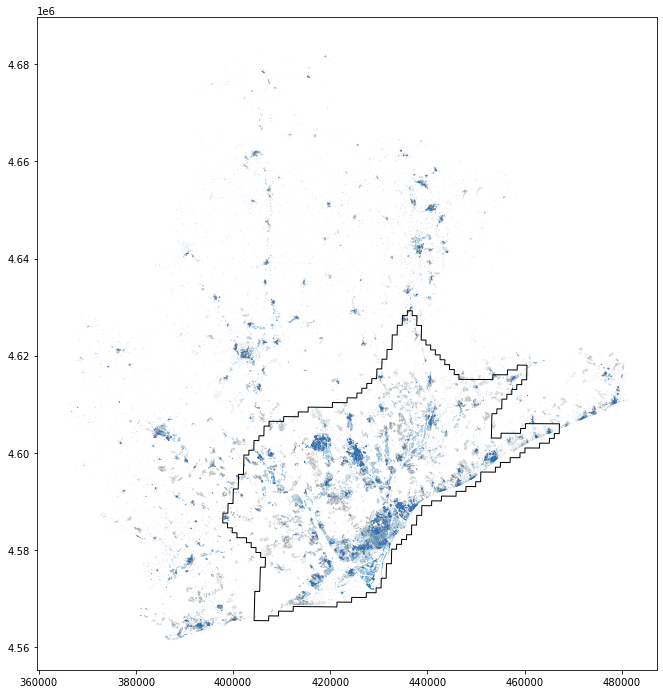

In [57]:
ax = fua[fua.eFUA_ID == 4523.0].to_crs(bcn.crs).plot(figsize=(12, 12), linewidth=1, edgecolor='k', facecolor='none')
catalonia.plot(ax=ax)

In [59]:
polygon = fua[fua.eFUA_ID == 4523.0].to_crs(bcn.crs).geometry.iloc[0]

In [60]:
barcelona_fua = catalonia.iloc[catalonia.sindex.query(polygon, predicate='intersects')]

<AxesSubplot:>

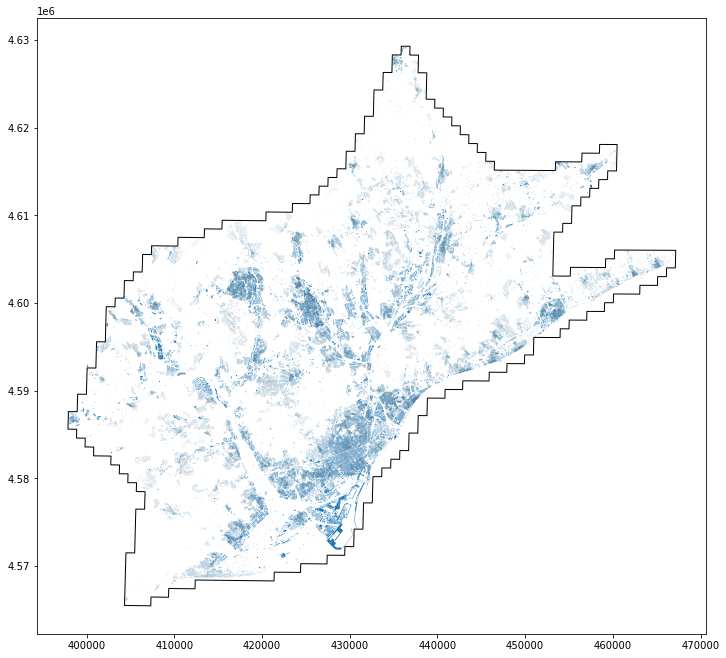

In [61]:
ax = fua[fua.eFUA_ID == 4523.0].to_crs(bcn.crs).plot(figsize=(12, 12), linewidth=1, edgecolor='k', facecolor='none')
barcelona_fua.plot(ax=ax)

In [62]:
barcelona_fua.to_parquet("../../urbangrammar_samba/sp_sig_concept/geometry/Barcelona_footprints_CAD.pq")

## Quito cadastre

Data for Quito are retrieved from http://gobiernoabierto.quito.gob.ec/?page_id=1122, which is an official open data portal. We just have to clip data to FUA and store as a parquet.

In [64]:
download('http://gobiernoabierto.quito.gob.ec/wp-content/uploads/documentos/descargashp/shp/Descargables/construcciones.zip',
         "../../urbangrammar_samba/sp_sig_concept/geometry/quito/", kind='zip')

Creating data folder...

file_sizes: 100%|███████████████████████████| 79.5M/79.5M [01:54<00:00, 697kB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/geometry/quito/


'../../urbangrammar_samba/sp_sig_concept/geometry/quito/'

In [65]:
quito = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/geometry/quito/')

<AxesSubplot:>

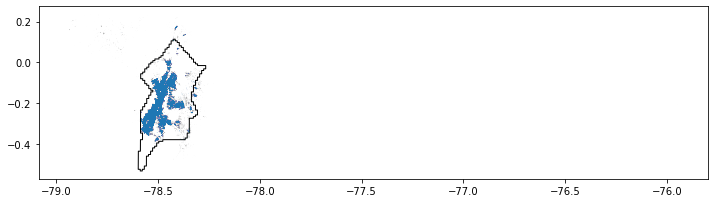

In [67]:
ax = fua[fua.eFUA_name == 'Quito'].to_crs(quito.crs).plot(figsize=(12, 12), linewidth=1, edgecolor='k', facecolor='none')
quito..plot(ax=ax)

In [69]:
polygon = fua[fua.eFUA_name == 'Quito'].to_crs(quito.crs).geometry.iloc[0]
quito_fua = quito.iloc[quito.sindex.query(polygon, predicate='intersects')]

<AxesSubplot:>

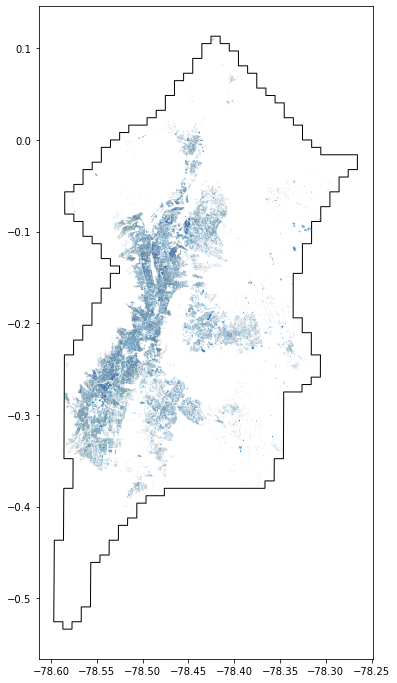

In [70]:
ax = fua[fua.eFUA_name == 'Quito'].to_crs(quito.crs).plot(figsize=(12, 12), linewidth=1, edgecolor='k', facecolor='none')
quito_fua.plot(ax=ax)

In [71]:
quito_fua.to_parquet("../../urbangrammar_samba/sp_sig_concept/geometry/Quito_footprints_CAD.pq")